# Segment Area

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from segment_anything import SamPredictor, SamAutomaticMaskGenerator

from app import load_image, get_embedding, SAM
from config import DATA_DIR

Using device: cuda:0
Loading model...
Loaded model in 24.62s


In [2]:
def show_mask(mask, ax):
    """Display a mask on a given matplotlib axis."""
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    """Plot coordinates as points on a given matplotlib axis with different colors based on labels."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    """Draw a box on a given matplotlib axis."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    """Display annotations on a given matplotlib axis."""
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
# Set fixed seeds for reproducibility across PyTorch and NumPy operations.
torch.manual_seed(2023)
torch.cuda.empty_cache()
torch.cuda.manual_seed(2023)
np.random.seed(2023)

In [4]:
PREDICTOR = SamPredictor(sam_model=SAM)

In [5]:
IMAGE_NAME = "317947"
IMAGE_PATH = str(DATA_DIR.joinpath(f"{IMAGE_NAME}.jpg"))

IMAGE = load_image(IMAGE_PATH)
PREDICTOR.set_image(image=IMAGE)

EMBEDDING = get_embedding(predictor=PREDICTOR, name=IMAGE_NAME)

Loaded image C:\Users\punit\projects\research\clotscape\data\317947.jpg with shape: (742, 932, 3)
Loading embedding from C:\Users\punit\projects\research\clotscape\data\embeddings\317947.npy


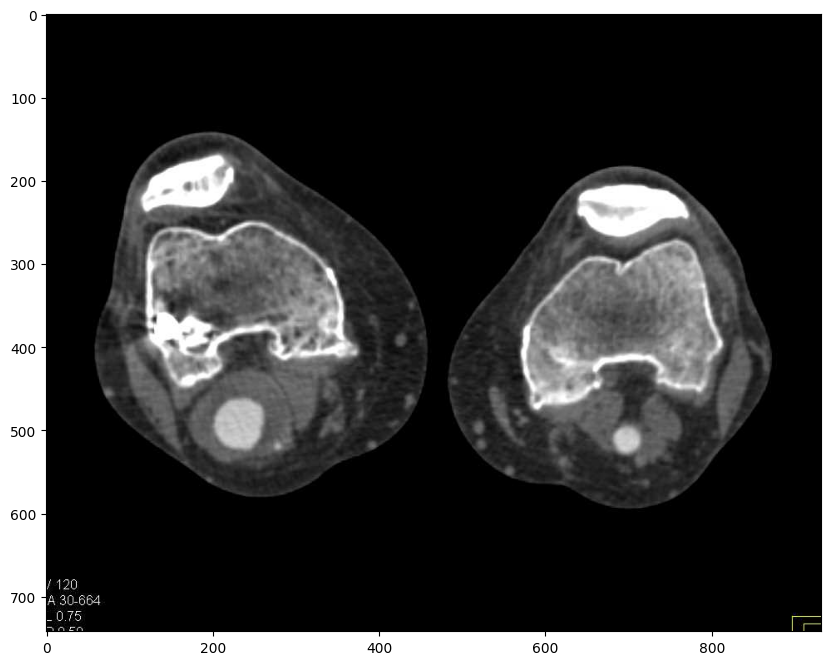

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(IMAGE)
plt.axis('on')
plt.show()

Set the inputs

In [7]:
input_box = np.array([575, 425, 775, 575])
input_point = np.array([[700, 515]])
input_label = np.array([0])

Predict masks

In [8]:
masks, scores, logits = PREDICTOR.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=True,
)
print(masks.shape)
print(scores)

(3, 742, 932)
[0.88645345 0.93821156 0.95910716]


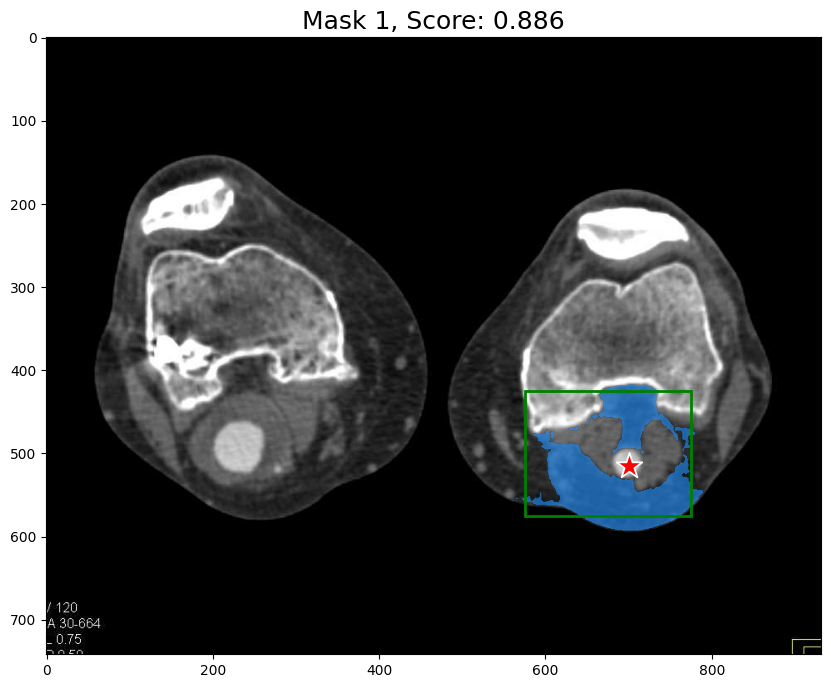

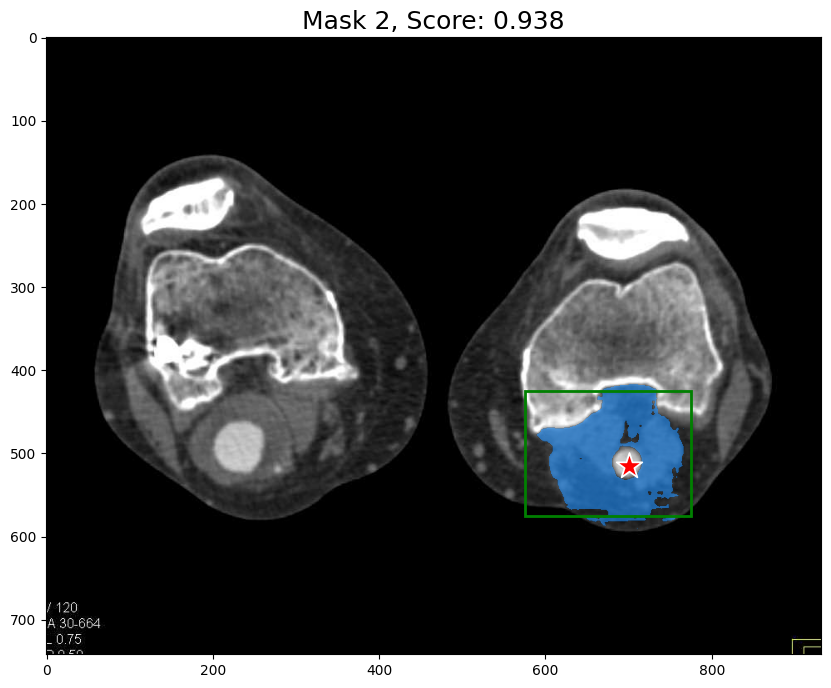

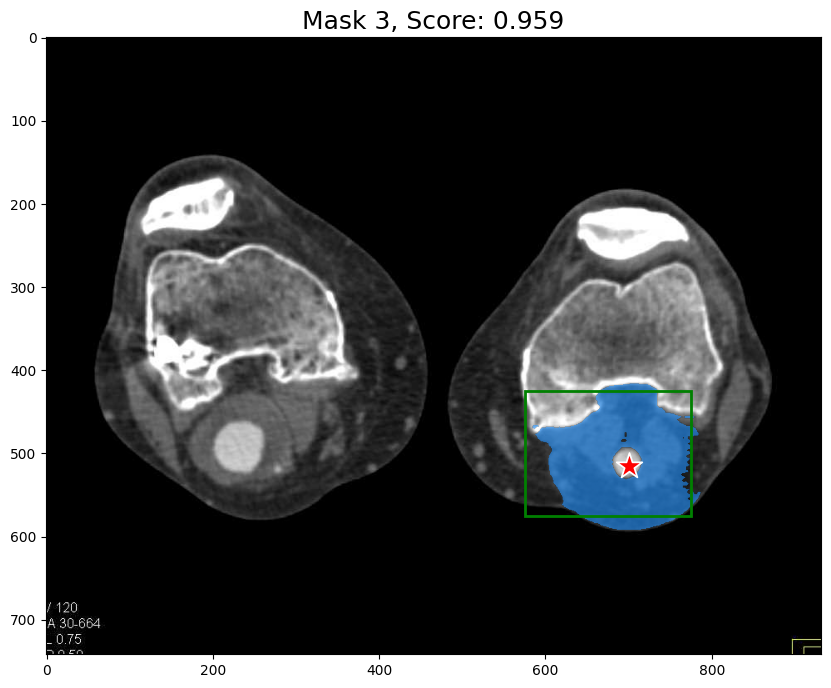

In [9]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(IMAGE)
    show_mask(mask, plt.gca())
    show_box(input_box, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('on')
    plt.show()

In [10]:
mask_generator = SamAutomaticMaskGenerator(SAM)

In [11]:
masks = mask_generator.generate(IMAGE)

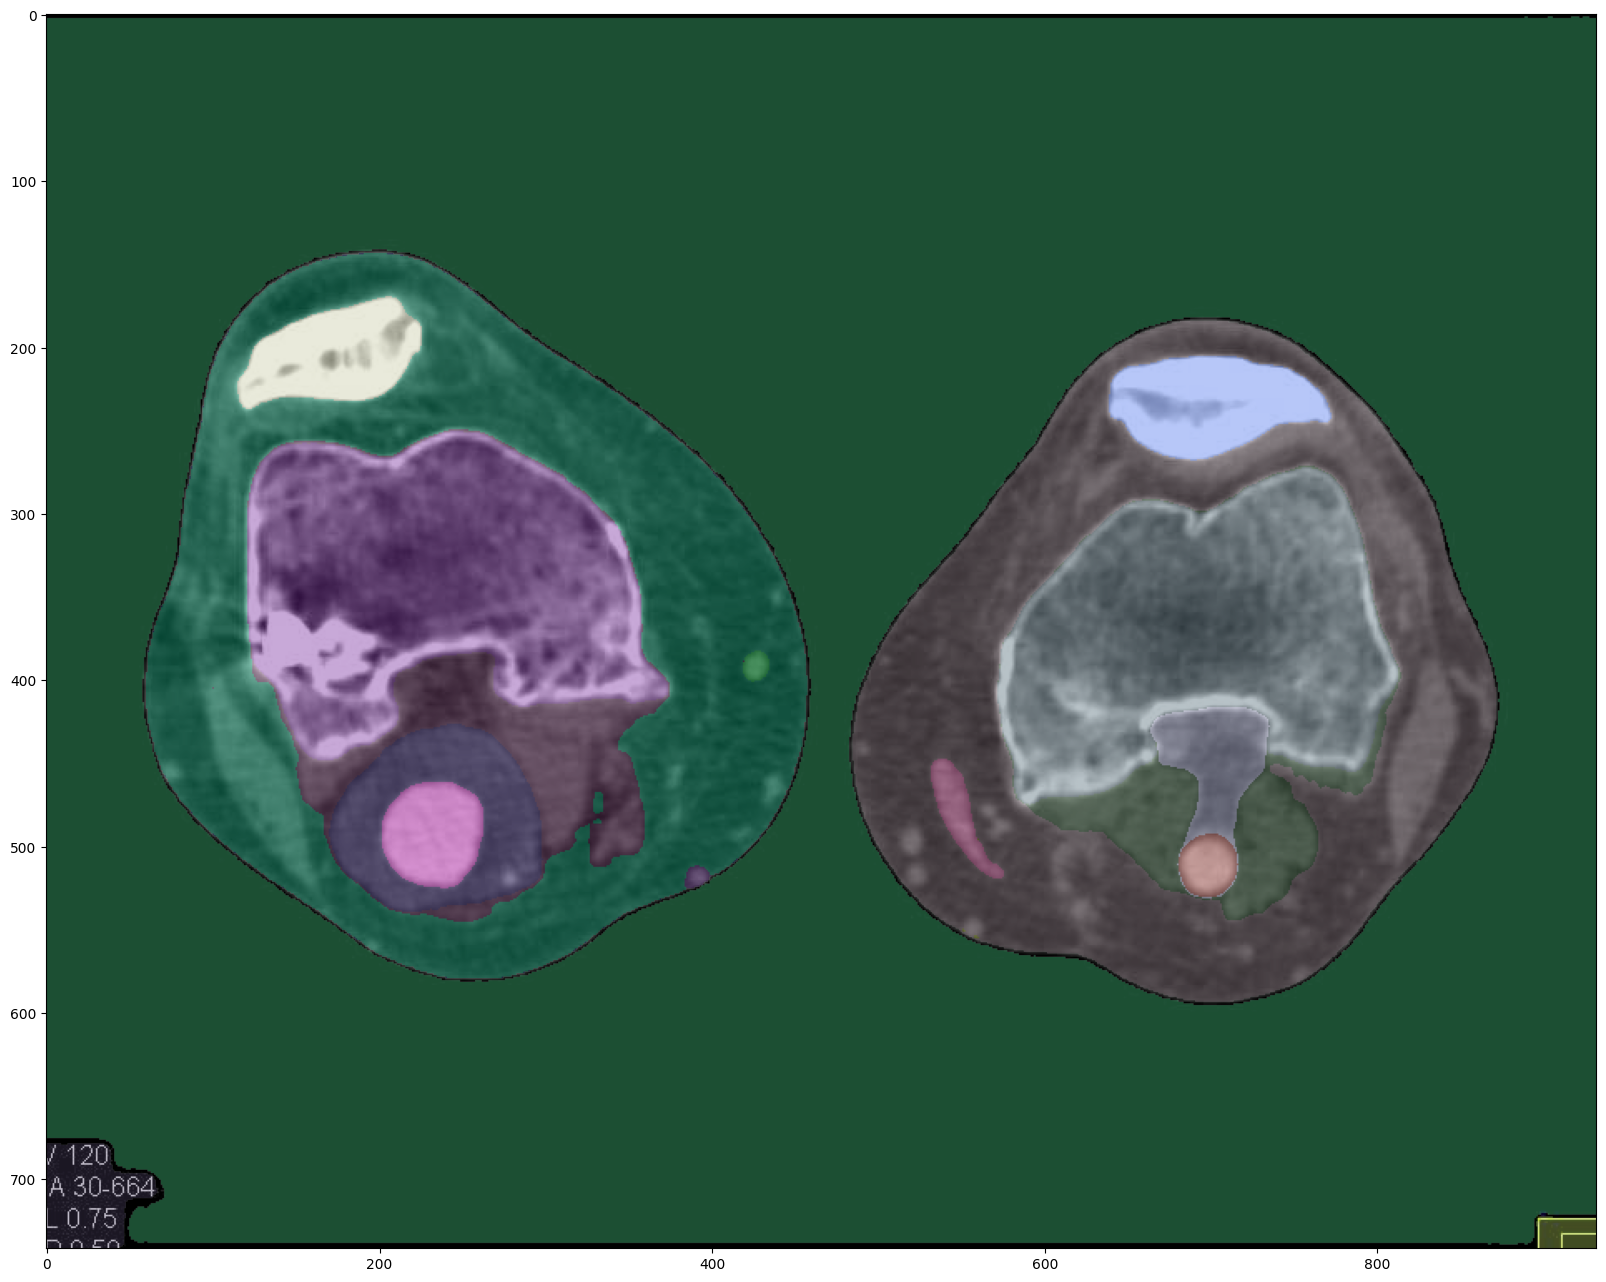

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(IMAGE)
show_anns(masks)
plt.axis('on')
plt.show() 

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=SAM,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

In [14]:
masks2 = mask_generator_2.generate(IMAGE)

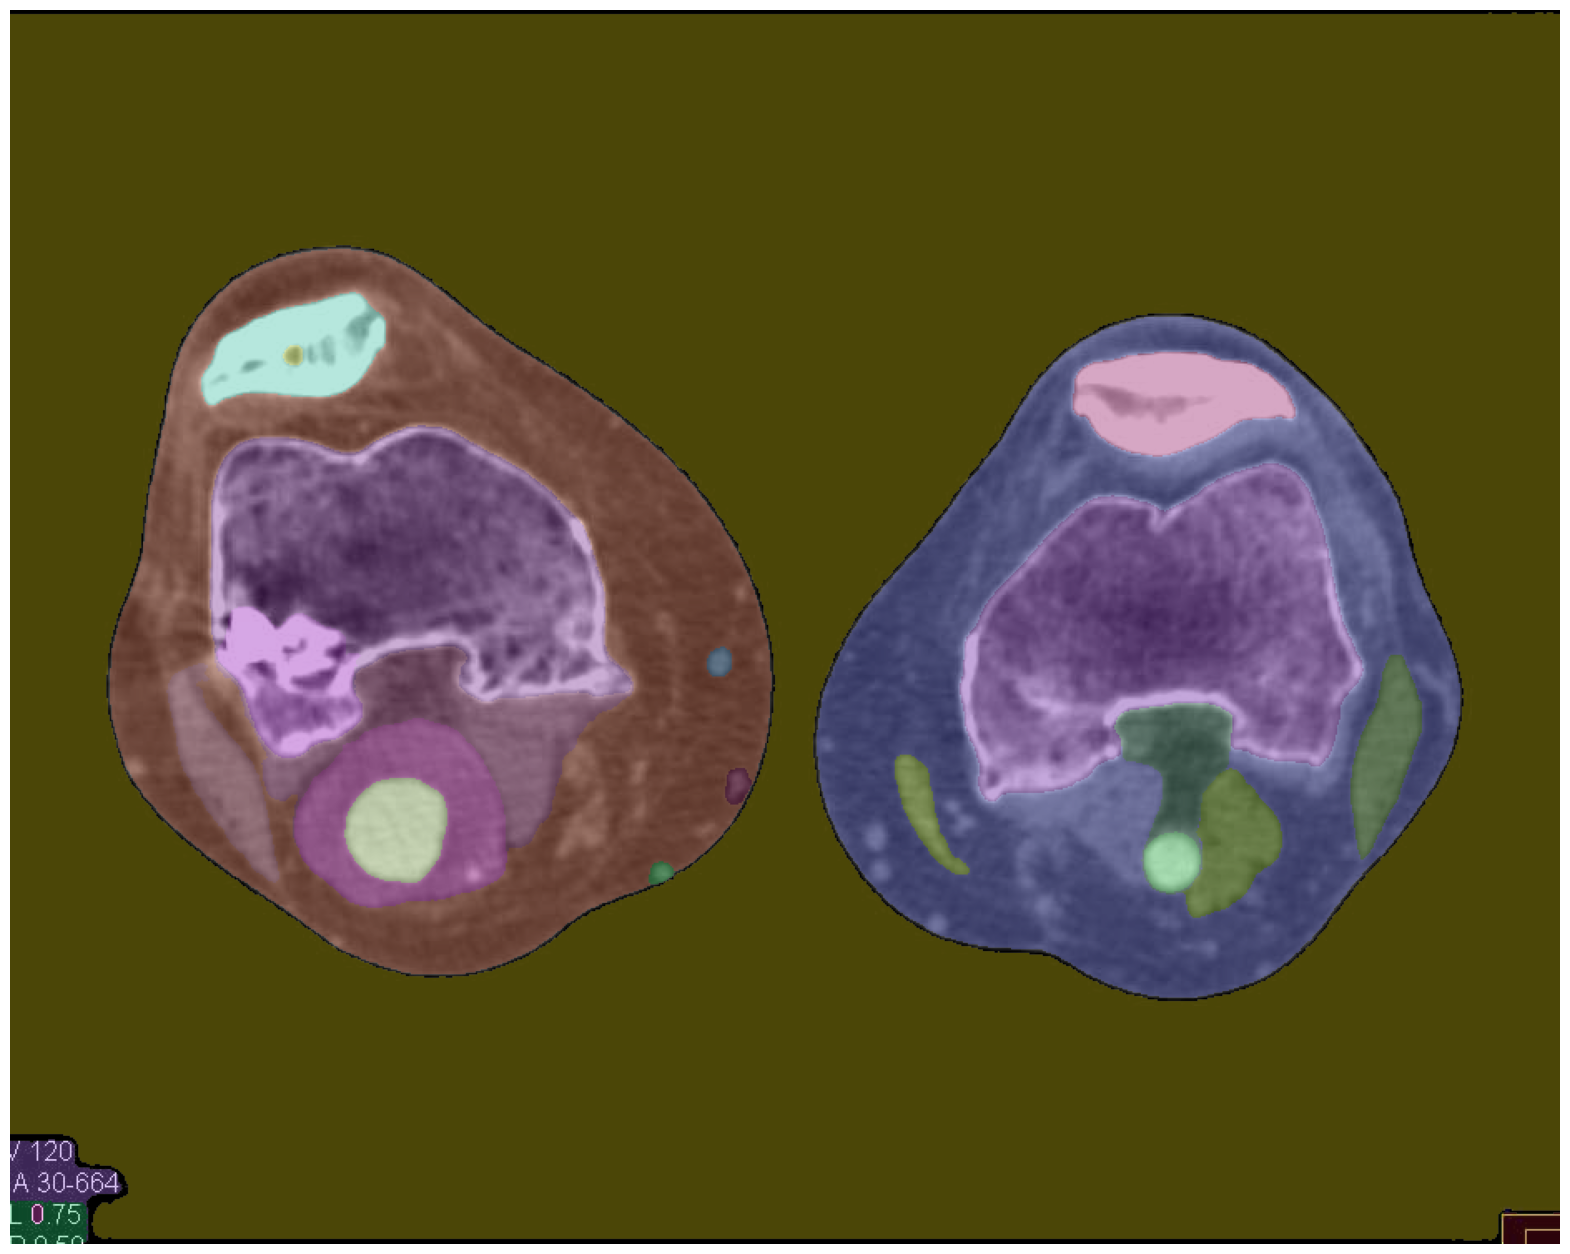

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(IMAGE)
show_anns(masks2)
plt.axis('on')
plt.show()